In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix, lil_matrix
from scipy import spatial
from scipy import stats

%matplotlib inline

# 1. Data preparation
1. Deal with missing values

In [4]:
data = pd.read_csv('data.csv', encoding='ISO-8859-1', engine='c')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
def count_na(data):
    na_count = pd.DataFrame(data.isnull().sum(), columns=['Count']).sort_values(by=['Count'], ascending=False)
    return na_count

In [9]:
count_na(data)

,Count
CustomerID,135080
Description,1454
InvoiceNo,0
StockCode,0
Quantity,0
InvoiceDate,0
UnitPrice,0
Country,0


In [11]:
data.InvoiceDate = pd.to_datetime(data.InvoiceDate, format="%m/%d/%Y %H:%M")
data["CustomerID"] = data["CustomerID"].fillna(-9999)
data["CustomerID"] = data["CustomerID"].apply(lambda x: str(x)[:-2])
data["Description"] = data["Description"].fillna("Unkown")

In [12]:
count_na(data)

,Count
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [13]:
data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


# 2. Deal with outliers etc

In [15]:
print(data.shape)

data = data[ np.abs((data['UnitPrice']-data['UnitPrice'].mean())/data['UnitPrice'].std()) <= 3]
data = data[ np.abs((data['Quantity']-data['Quantity'].mean())/data['Quantity'].std()) <= 3]

data = data[data["UnitPrice"] >= 0 ]
data = data[data["InvoiceNo"].astype(str).str[0] != "C"]
data = data[data["InvoiceNo"].astype(str).str[0] != "A"]
data = data[data["Quantity"] > 0 ]

print(data.shape)

(530795, 8)
(519486, 8)


In [16]:
data.describe()

,Quantity,UnitPrice
count,519486.000000,519486.000000
mean,7.335439,3.181038
std,10.075981,3.116406
min,1.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,86.000000,23.530000


In [17]:
data['Revenue'] = data['Quantity']*data['UnitPrice']

data['Date'] = data['InvoiceDate'].dt.date
data['Day'] = data['InvoiceDate'].dt.day
data['Month'] = data['InvoiceDate'].dt.month
data['Year'] = data['InvoiceDate'].dt.year
data['Hour'] = data['InvoiceDate'].dt.hour
data['Week'] = data['InvoiceDate'].dt.week
data['Minute'] = data['InvoiceDate'].dt.minute

In [18]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Date,Day,Month,Year,Hour,Week,Minute
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,178,United Kingdom,15.30,2010-12-01,1,12,2010,8,48,26
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,178,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,178,United Kingdom,22.00,2010-12-01,1,12,2010,8,48,26
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,178,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,178,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26


# 2. Historical revenue

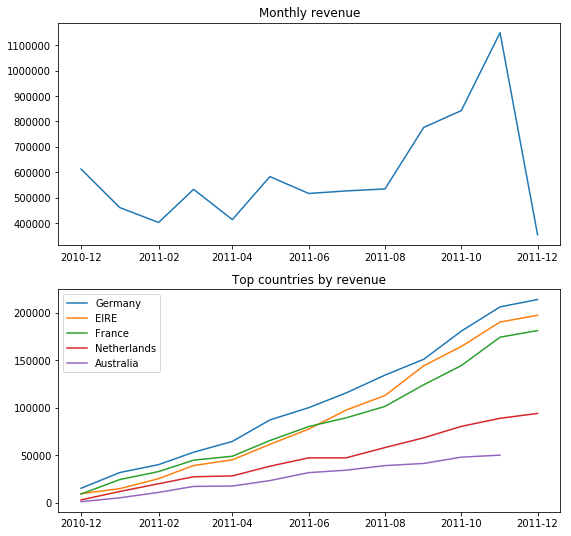

In [19]:
fig, ax = plt.subplots(2,1, figsize=(9, 9))

sales = data[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
sales['Day'] = 1
sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
sales = sales.set_index('Date')
sales = sales.drop(['Year', 'Month', 'Day'], axis=1)

ax[0].plot(sales)
ax[0].set_title('Monthly revenue')        


sales_top = data[['Revenue', 'Country']].groupby(['Country']).sum().reset_index().sort_values(by='Revenue', ascending=False)['Country'][1:6]

for c in sales_top:
    sales = data[data['Country'] == c]
    sales = sales[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
    sales['Day'] = 1
    sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
    sales = sales.set_index('Date')
    sales = sales.drop(['Year', 'Month', 'Day'], axis=1)
    ax[1].plot(sales.cumsum(), label=c)    
    ax[1].legend()
    ax[1].set_title('Top countries by revenue')            
    
plt.show()


# 3. Transaction amount time distribution

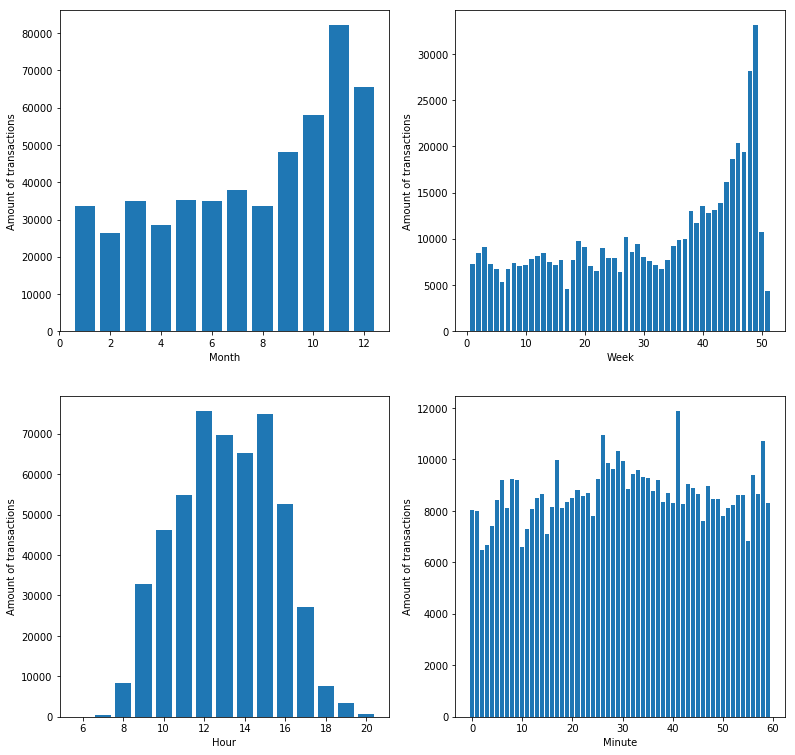

In [20]:
grps = np.array([['Month', 'Week'], ['Hour', 'Minute']])

fig, ax = plt.subplots(grps.shape[0],grps.shape[1], figsize=(13, 13))

for i in range(0, grps.shape[0]):
    for j in range(0, grps.shape[1]):
        grp_data = data[[grps[i,j], 'InvoiceNo']].groupby([grps[i,j]]).count()
        ax[i,j].bar(x=grp_data.index, height='InvoiceNo', data=grp_data)
        ax[i,j].set_ylabel('Amount of transactions')
        ax[i,j].set_xlabel(grps[i,j])
        
plt.show()

# 4. Taking a look at top selling products in different countries

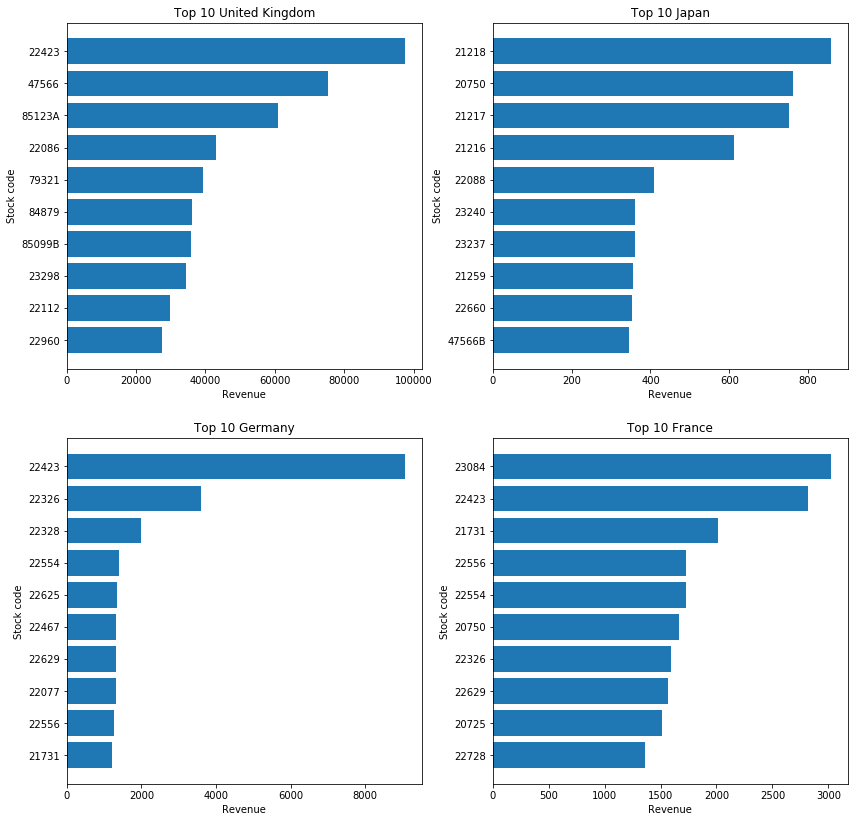

In [21]:
ctry = np.array([['United Kingdom', 'Japan'], ['Germany', 'France']])
fltr = ['DOT', 'POST', 'M']
top_n = 10

fig, ax = plt.subplots(grps.shape[0],grps.shape[1], figsize=(14, 14))

for i in range(0, ctry.shape[0]):
    for j in range(0, ctry.shape[1]):
        grp_data = data[data['Country'] == ctry[i,j]]
        grp_data = grp_data[~grp_data['StockCode'].isin(fltr)]
        grp_data = grp_data[['StockCode', 'Revenue']].groupby(['StockCode']).sum().sort_values(by='Revenue', ascending=False)        
        grp_data = grp_data[0:top_n]    
        grp_data = grp_data.reset_index()
        
        ax[i,j].barh(y=grp_data.index, width='Revenue', data=grp_data)
        ax[i,j].invert_yaxis()
        ax[i,j].set_yticks(range(0,top_n))
        ax[i,j].set_yticklabels(grp_data['StockCode'].tolist())
        ax[i,j].set_ylabel('Stock code')        
        ax[i,j].set_xlabel('Revenue')                
        ax[i,j].set_title('Top 10 ' + ctry[i,j])        
        
plt.show()

# 5. Taking a look at top selling products globally

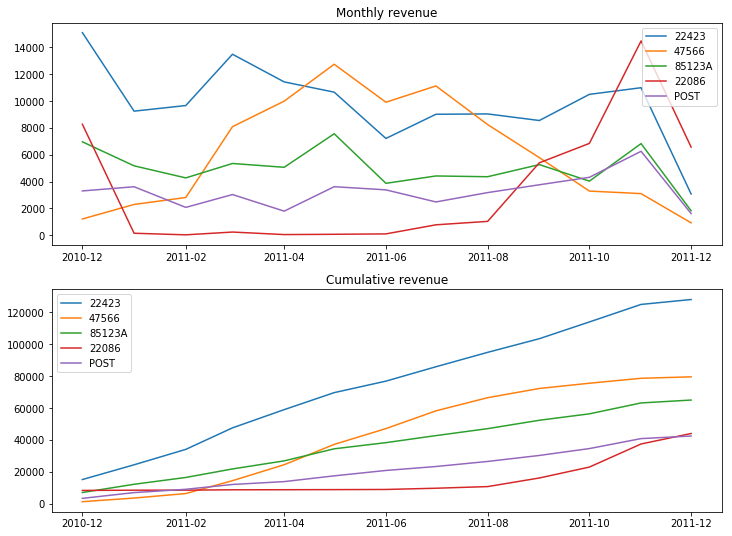

In [22]:
stock_top = data[['Revenue', 'StockCode']].groupby(['StockCode']).sum().reset_index().sort_values(by='Revenue', ascending=False)['StockCode'][0:5]

fig, ax = plt.subplots(2,1, figsize=(12, 9))

for c in stock_top:
    sales = data[data['StockCode'] == c]
    sales = sales[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
    sales['Day'] = 1
    sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
    sales = sales.set_index('Date')
    sales = sales.drop(['Year', 'Month', 'Day'], axis=1)
    ax[0].plot(sales.Revenue, label=c)
    ax[0].legend()
    ax[0].set_title('Monthly revenue')            

for c in stock_top:
    sales = data[data['StockCode'] == c]
    sales = sales[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
    sales['Day'] = 1
    sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
    sales = sales.set_index('Date')
    sales = sales.drop(['Year', 'Month', 'Day'], axis=1)
    ax[1].plot(sales.cumsum(), label=c)
    ax[1].legend()
    ax[1].set_title('Cumulative revenue')        

# 6. Taking an in depth look at a Product

# To answer question such as:

    Who bought the most of this specific product.
    Clients from which countries are most interested in this product.
    How has the product been doing in terms of revenue historically.
    Is the product purchased in bulk or are they purchased in smaller quantities.

I present you with the following charts.

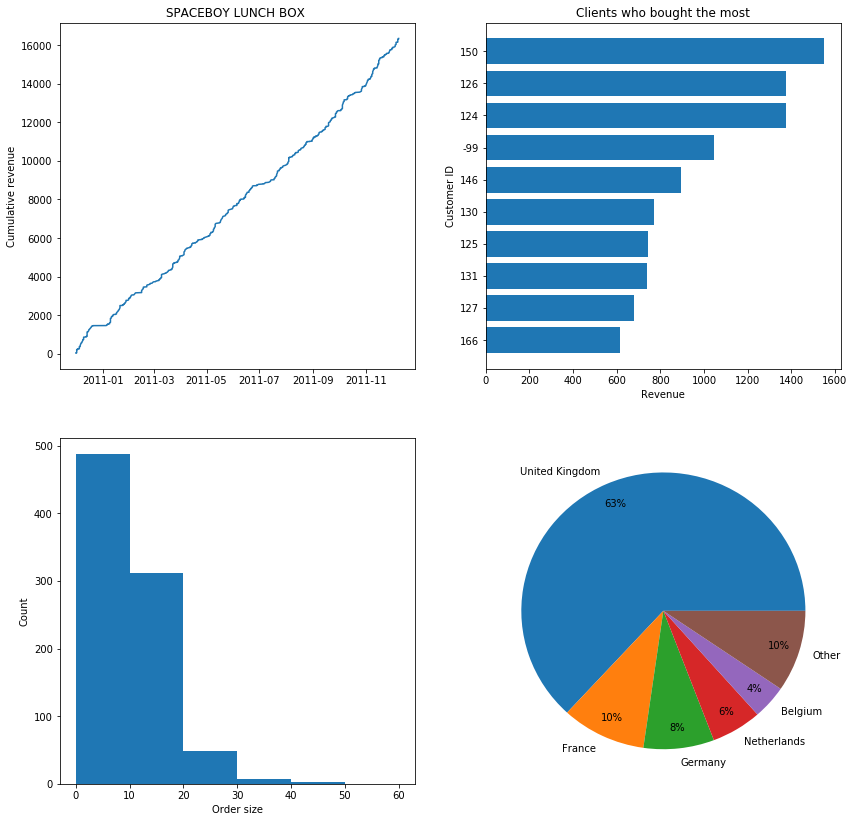

In [23]:
def top_stock(stockcode, top_n):
    """ Plot cumulative sales in pound sterling, 
    clients who bought the most, distribution of order size
    and pie chart with country % of buyers.    
    Parameters:
    stockcode: string with stock id
    top_n: how many bars etc to plot"""

    stock = data[data['StockCode'] == stockcode].sort_values(['InvoiceDate'])
    stock['ValueCum'] = stock['Revenue'].cumsum()

    top_buyers = stock[['Revenue', 'CustomerID']].groupby(['CustomerID']).sum().sort_values(by='Revenue', ascending=False).reset_index()
    top_buyers = top_buyers[0:top_n]

    ctry = stock[['Country', 'Revenue']].groupby(['Country']).sum().sort_values(by='Revenue', ascending=False)
    ctry = ((ctry/ctry.sum())*100).round(2)
    ctry = ctry[0:int(top_n/2)]
    ctry = ctry.append(pd.DataFrame(data=[100-ctry.sum()], columns=['Revenue'], index=['Other'] ))

    plt.clf()

    fig, ax = plt.subplots(grps.shape[0],grps.shape[1], figsize=(14, 14))
    
    ax[0,0].plot(stock['InvoiceDate'].dt.date, stock['ValueCum'])
    ax[0,0].set_ylabel('Cumulative revenue')        
    ax[0,0].set_title(stock['Description'].iloc[0])    

    ax[0,1].invert_yaxis()
    ax[0,1].barh(y=top_buyers.index, width='Revenue', data=top_buyers)
    ax[0,1].set_yticks(range(0,top_n))
    ax[0,1].set_yticklabels(top_buyers['CustomerID'].tolist())
    ax[0,1].set_ylabel('Customer ID')        
    ax[0,1].set_xlabel('Revenue')      
    ax[0,1].set_title("Clients who bought the most")        

    ax[1,0].hist(stock['Quantity'], bins=range(0,stock['Quantity'].max(), top_n) )
    ax[1,0].set_ylabel('Count')        
    ax[1,0].set_xlabel('Order size')     

    ax[1,1].pie(ctry['Revenue'], labels=ctry.index,  autopct='%1.0f%%', pctdistance=0.85)

    plt.show()
    
top_stock(stockcode="22629", top_n = 10)    

# 7. Build customer table

So in this part we would like to get know the retailers clients a little better. We will be interested to see the following:

    Since when is the client a customer.
    When was his last order.
    How many days is the client a customer.
    How many days have past since last order.
    Has a client ordered anything in the last 30, 90, 180 days or can we say he's a client no more.
    How frequently do orders arrive.
    Is the order arrival frequency below one week, two weeks, a month or lest frequent.
    How many unique products has the customer ordered.
    Average amount on invoice.
    Total units sold.
    Total amount of inoices.

Obviously I'll be disregarding purchases where the client is not known.

In [26]:
def interarrival(cid):
    s = data[data['CustomerID'] == str(cid)].sort_values(by=['Date'])['Date']    
    x = (s - s.shift(1)).dropna()
    
    if x.empty:
        return 0
    
    else:
        return x.dt.days.mean()



In [27]:
c_data = data[['CustomerID', 'InvoiceDate']].groupby('CustomerID', as_index=False)['InvoiceDate'].min()
c_data.columns = ['CustomerID', 'i_first']

c_data['i_first'] = data[['CustomerID', 'InvoiceDate']].groupby('CustomerID', as_index=False)['InvoiceDate'].min()['InvoiceDate']
c_data['i_last'] = data[['CustomerID', 'InvoiceDate']].groupby('CustomerID', as_index=False)['InvoiceDate'].max()['InvoiceDate']

c_data['d_as_customer']  = (max(c_data['i_last']) - c_data['i_first']).dt.days
c_data['d_last_invoice']  = (max(c_data['i_last']) - c_data['i_last'] ).dt.days

c_data['i_last_30D']  = c_data['d_last_invoice'].apply(lambda x: 1 if x < 30 else 0)
c_data['i_last_90D']  = c_data['d_last_invoice'].apply(lambda x: 1 if x >= 30 and x < 90 else 0)
c_data['i_last_180D'] = c_data['d_last_invoice'].apply(lambda x: 1 if x >= 90 and x < 180 else 0)
c_data['i_over_180D'] = c_data['d_last_invoice'].apply(lambda x: 1 if x >= 180 else 0)

c_data['i_arrival_rate'] = c_data['CustomerID'].apply(interarrival)

c_data['t_invoices'] = data[['CustomerID', 'InvoiceDate']].groupby('CustomerID', as_index=False)['InvoiceDate'].count()['InvoiceDate']
c_data['t_units'] = data[['CustomerID', 'Quantity']].groupby('CustomerID', as_index=False)['Quantity'].sum()['Quantity']
c_data['t_rev'] = data[['CustomerID', 'Revenue']].groupby('CustomerID', as_index=False)['Revenue'].sum()['Revenue']

c_data['u_orders'] = data[['CustomerID', 'StockCode']].groupby('CustomerID', as_index=False).nunique()['StockCode']
c_data['pct_rev_total'] = (c_data['t_rev']/data['Revenue'].sum())*100
c_data['avg_rev'] = data[['CustomerID', 'Revenue']].groupby('CustomerID', as_index=False)['Revenue'].mean()['Revenue']

c_data['a_rate_week'] = c_data['i_arrival_rate'].apply(lambda x:  1 if x <  7  else 0)
c_data['a_rate_2week'] = c_data['i_arrival_rate'].apply(lambda x: 1 if x >= 7  and x < 14 else 0)
c_data['a_rate_month'] = c_data['i_arrival_rate'].apply(lambda x: 1 if x >= 14 and x < 30 else 0)
c_data['a_rate_small'] = c_data['i_arrival_rate'].apply(lambda x:  1 if x >= 30 else 0)

c_data = c_data[c_data['CustomerID'] != str(-9999)]

In [28]:
c_data.round(2).head()

,CustomerID,i_first,i_last,d_as_customer,d_last_invoice,i_last_30D,i_last_90D,i_last_180D,i_over_180D,i_arrival_rate,t_invoices,t_units,t_rev,u_orders,pct_rev_total,avg_rev,a_rate_week,a_rate_2week,a_rate_month,a_rate_small
0,-99,2010-12-01 11:52:00,2011-12-09 10:26:00,373,0,1,0,0,0,0.00,130954,384470,1305008.49,3491,16.95,9.97,1,0,0,0
1,123,2010-12-03 16:35:00,2011-12-08 10:26:00,370,1,1,0,0,0,0.12,3141,35455,67833.29,1252,0.88,21.60,1,0,0,0
2,124,2010-12-01 10:03:00,2011-12-09 10:10:00,373,0,1,0,0,0,0.05,7806,108426,233754.38,1751,3.04,29.95,1,0,0,0
3,125,2010-12-01 08:45:00,2011-12-09 12:09:00,373,0,1,0,0,0,0.06,6214,66537,126887.71,1624,1.65,20.42,1,0,0,0
4,126,2010-12-01 13:04:00,2011-12-09 12:50:00,372,0,1,0,0,0,0.05,6974,85505,162459.59,1417,2.11,23.30,1,0,0,0


# 8. Visualize some aspects of the table
1. Individual features

Text(0.5,1,'Log of days between invoices')

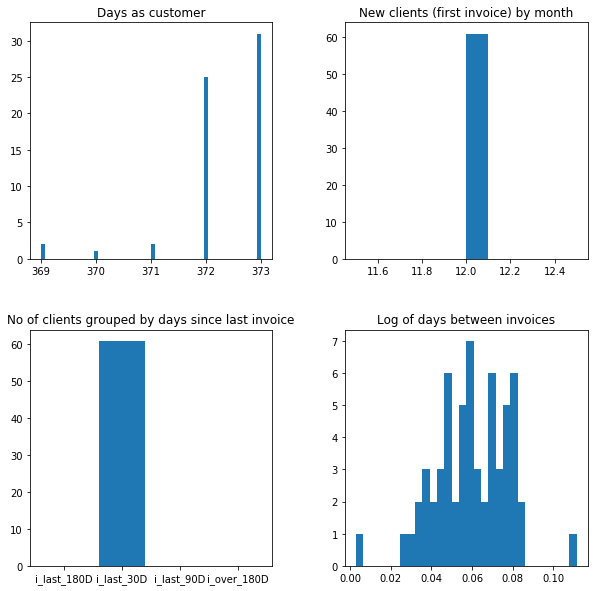

In [29]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))

plt.subplots_adjust(hspace=0.3, wspace=0.3)

ax[0,0].hist(c_data['d_as_customer'], bins=50)
ax[0,0].set_title('Days as customer')        

ax[1,0].bar(x=['i_last_30D', 'i_last_90D', 'i_last_180D', 'i_over_180D'], height=c_data[['i_last_30D', 'i_last_90D', 'i_last_180D', 'i_over_180D']].sum())
ax[1,0].set_title('No of clients grouped by days since last invoice')        

ax[0,1].hist(c_data['i_first'].dt.month)
ax[0,1].set_title('New clients (first invoice) by month')        

ax[1,1].hist(c_data['i_arrival_rate'].apply(lambda x: np.log(x+1)), bins=30)
ax[1,1].set_title('Log of days between invoices')        

# 2. Correlation matrix of continuous features

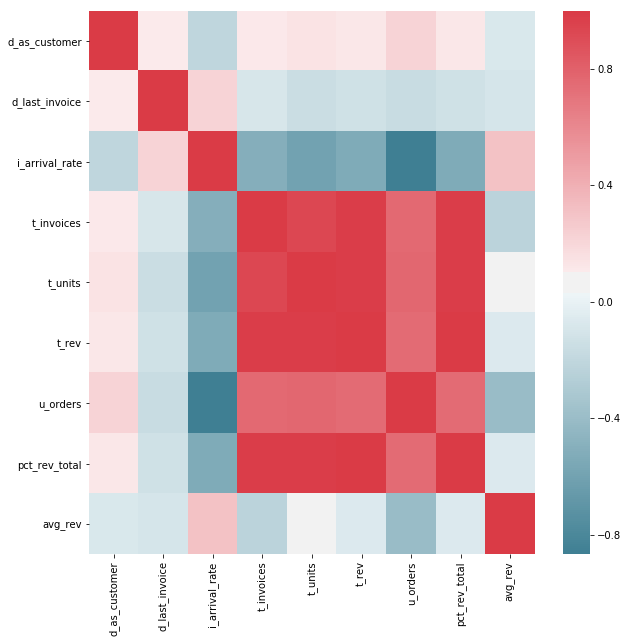

In [30]:
c_data_corr = c_data.drop(['i_last_30D', 'i_last_90D', 'i_last_180D', 'i_over_180D', 
                           'a_rate_week', 'a_rate_2week', 'a_rate_month', 'a_rate_small'], axis=1).corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(c_data_corr, cmap=cmap)
plt.show()


# 3. Build multicriterial ranking

Now I'm going to rank clients based on attributes in the customer table presented above. The features I'll use are as follows:

    Days as a customer
    Total purchases (total amount of invoices)
    Total revenue
    Total units of product purchased
    Average revenue
    Order arrival rate
    Time of last invoice (in such a manner that penalises inactive clients).


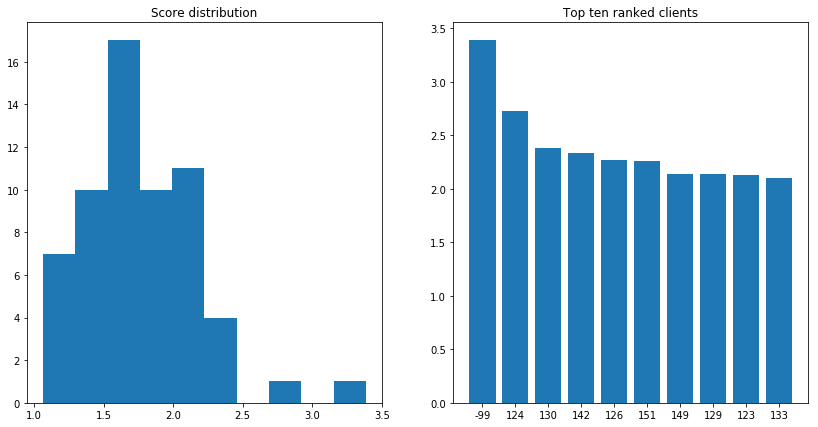

In [31]:
rk = c_data.copy()

rk['t_rev'] = rk['t_rev'].apply(lambda x: np.log(x))
rk['t_units'] = rk['t_units'].apply(lambda x: np.log(x))

cols = ['d_as_customer', 't_invoices', 't_rev', 't_units', 'avg_rev', 'i_arrival_rate']

for c in cols:
    rk.loc[:,str(c)] = rk[str(c)].apply(lambda x: (x-rk[str(c)].min())/(rk[str(c)].max()-rk[str(c)].min()))
    
rk['Active'] = (3*rk['i_last_30D'] + 2*rk['i_last_90D'] + rk['i_last_180D'] - 4*rk['i_over_180D'])/10
cols.append('Active')
cols.append('CustomerID')
rk = rk[cols]
rk['Score'] = rk.iloc[:,1:rk.shape[1]].sum(axis=1)
rk = rk.loc[:,['CustomerID', 'Score']]
rk = rk.sort_values(by=['Score'], ascending=False)
rk = rk.reset_index(drop=True)

fig, ax = plt.subplots(1,2, figsize=(14, 7))

ax[0].hist(rk['Score'].values)
ax[0].set_title('Score distribution')    

ax[1].bar(x=np.arange(10), height=rk['Score'][0:10])
ax[1].set_xticks(np.arange(10))
ax[1].set_xticklabels(rk['CustomerID'][0:10].tolist())
ax[1].set_title("Top ten ranked clients")    

plt.show()

# 9. Builder a simple recommender

# 1. Pivot data and create sparse matrix

In [32]:
def to_sparse(data):
    d = data[['StockCode', 'CustomerID', 'Revenue']].groupby(['StockCode', 'CustomerID']).count()#[1:10000]
    d = d.reset_index()
    d = d[d['CustomerID'] != '-9999']
    piv = pd.pivot_table(d, index='CustomerID', columns='StockCode', values='Revenue')
    piv = piv.dropna(axis=1, how='all')
    print(piv.iloc[0:10,0:5])
    cols = piv.columns
    piv = piv.fillna(0)
    piv = lil_matrix(piv)
    return piv,cols
piv,cols = to_sparse(data)


StockCode   10002  10080  10120  10123C  10124A
CustomerID                                     
-99          22.0    2.0    NaN     NaN     NaN
123           NaN    NaN    NaN     NaN     NaN
124           1.0    NaN    NaN     NaN     NaN
125           2.0    NaN    1.0     NaN     NaN
126           5.0    NaN    NaN     NaN     NaN
127           3.0    NaN    2.0     NaN     NaN
128           3.0    NaN    NaN     NaN     NaN
129           NaN    NaN    NaN     NaN     NaN
130           1.0    1.0    NaN     NaN     NaN
131           1.0    NaN    NaN     NaN     1.0


# 2. Compute columnwise similarities for given product

In [33]:
def get_sims(matrix, col_index):
    
    cosine = lambda x,y: 1-spatial.distance.cosine(x,y)
    euclidean = lambda x,y: spatial.distance.euclidean(x,y)    
    pearson = lambda x,y: float(stats.pearsonr(x,y)[0])
    
    corrs = []
    col = matrix[:,col_index].todense()    
    col_nums = range(0, piv.shape[1])
    
    def calculate(i):    
        tmp_col = matrix[:,i].todense()            
        return [i, euclidean(col,tmp_col), cosine(col, tmp_col), pearson(col, tmp_col)]
        
    sims = list(map(calculate, col_nums))
        
    return pd.DataFrame(data= sims, index=cols, columns=['ColNo', 'Euclidean', 'Cosine', 'Pearson'])

product = list(cols).index('23240')
most_similar = get_sims(matrix=piv, col_index=product)
most_similar = most_similar.join(data[['StockCode', 'Description']].groupby(['StockCode', 'Description']).count())
most_similar.reset_index(inplace=True)

# 3.List Reccomendations

In [34]:
most_similar.sort_values(by=['Cosine'], ascending=False)[0:20]

,StockCode,Description,ColNo,Euclidean,Cosine,Pearson
2457,23240,SET OF 4 KNICK KNACK TINS DOILY,2082,0.000000,1.000000,1.000000
2455,23240,SET OF 4 KNICK KNACK TINS DOILEY,2082,0.000000,1.000000,1.000000
2456,23240,SET OF 4 KNICK KNACK TINS DOILEY,2082,0.000000,1.000000,1.000000
2447,23236,DOILEY BISCUIT TIN,2078,42.130749,0.912587,0.847241
2448,23236,DOILEY STORAGE TIN,2078,42.130749,0.912587,0.847241
2449,23236,STORAGE TIN VINTAGE DOILEY,2078,42.130749,0.912587,0.847241
2450,23236,STORAGE TIN VINTAGE DOILY,2078,42.130749,0.912587,0.847241
2285,23108,SET OF 10 LED DOLLY LIGHTS,1951,47.465777,0.902547,0.755431
1229,22138,BAKING SET 9 PIECE RETROSPOT,1052,73.136858,0.896961,0.739700
2479,23256,CHILDRENS CUTLERY SPACEBOY,2096,43.439613,0.889338,0.793577
